In [1]:
from time import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from skimage.transform import integral_image
from skimage.feature import haar_like_feature

### 数据准备
使用的数据集为Caltech 10k Web Faces<br>
annotation格式为:<br>
image-name Leye-x Leye-y Reye-x Reye-y nose-x nose-y mouth-x mouth-y<br>
转换为灰度图像

In [2]:
# 读取标注文件
annotations_file = "/root/autodl-tmp/mlhw/hw1/XJTU-AUTO300527-homework/face recognition/WebFaces_GroundThruth.txt"
with open(annotations_file, 'r') as f:
    annotations = f.readlines()

# 构建图像路径和标签列表
image_paths = []
labels = []
for annotation in annotations[:200]:
    parts = annotation.strip().split()
    image_name = parts[0]
    image_path = os.path.join("/root/autodl-tmp/mlhw/hw1/Caltech_WebFaces", image_name)
    if os.path.exists(image_path):
        image_paths.append(image_path)
        label = list(map(float, parts[1:]))
        labels.append(label)
# 转换为灰度图像和光照归一化的灰度图像
gray_images = []
normalized_images = []
for path, label in zip(image_paths, labels):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mean_brightness = np.mean(img)
    normalized_img = img - mean_brightness
    normalized_images.append(normalized_img)
    gray_images.append(img)

取其中一张图查看

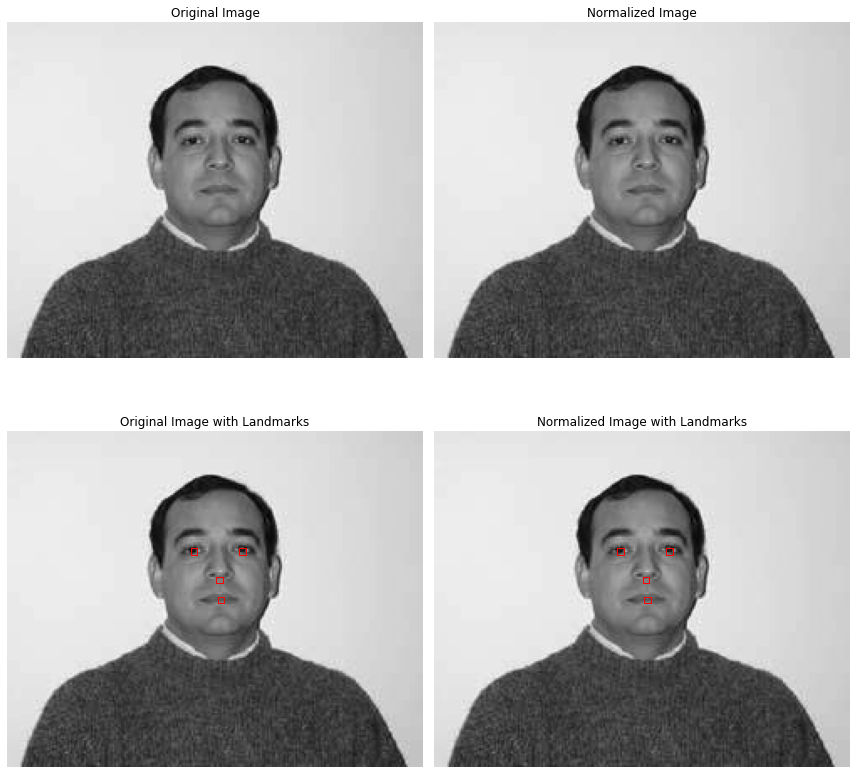

In [3]:
# 获取第一个样本的图像和对应的八个参数
image = gray_images[20]
normalized_image = normalized_images[20]
parameters = labels[20]

# 创建 Matplotlib 子图
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 显示原始图像和光照归一化图像
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(normalized_image, cmap='gray')
axes[0, 1].set_title('Normalized Image')
axes[0, 1].axis('off')

# 在原始图像上标注位置
axes[1, 0].imshow(image, cmap='gray')
axes[1, 0].set_title('Original Image with Landmarks')
axes[1, 0].axis('off')
for i in range(0, len(parameters), 2):
    x = int(parameters[i])  # x 坐标
    y = int(parameters[i + 1])  # y 坐标
    # 绘制矩形框
    rect = plt.Rectangle((x - 2, y - 2), 4, 4, edgecolor='r', facecolor='none')
    axes[1, 0].add_patch(rect)

# 在光照归一化图像上标注位置
axes[1, 1].imshow(normalized_image, cmap='gray')
axes[1, 1].set_title('Normalized Image with Landmarks')
axes[1, 1].axis('off')
for i in range(0, len(parameters), 2):
    x = int(parameters[i])  # x 坐标
    y = int(parameters[i + 1])  # y 坐标
    # 绘制矩形框
    rect = plt.Rectangle((x - 2, y - 2), 4, 4, edgecolor='r', facecolor='none')
    axes[1, 1].add_patch(rect)

# 显示图像和标注
plt.tight_layout()
plt.show()


### 划分训练集和测试集

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    normalized_images, labels, train_size=0.8, random_state = 229
)

In [5]:
print(len(normalized_images))
print(len(X_train))
print(len(X_test))
print(len(labels))
print(len(y_train))
print(len(y_test))

200
160
40
200
160
40


(200, 248)


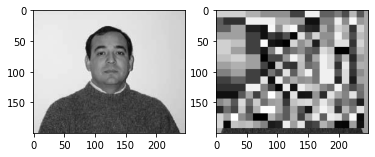

In [6]:
subwin_size = 12
image_test = np.copy(gray_images[20])
print(image_test.shape)
result_test = np.copy(image_test)
h, w = image_test.shape
# 移动窗口并计算Haar特征
for i in range(0, h - subwin_size + 1, subwin_size):
    for j in range(0, w - subwin_size + 1, subwin_size):
        # 获取当前窗口
        window = image_test[i:i+subwin_size, j:j+subwin_size]
        minus_window = window[:,subwin_size//3:2*subwin_size//3]
        # 计算Haar特征
        feature = integral_image(window)[subwin_size-1][subwin_size-1] - 2* integral_image(minus_window)[subwin_size-1][minus_window.shape[1]-1]
        # 将计算得到的Haar特征赋值给输出图像的相应区域
        result_test[i:i+subwin_size, j:j+subwin_size] = feature

# 显示原始图像和赋值后的图像
plt.subplot(1, 2, 1)
plt.imshow(image_test, cmap='gray')


plt.subplot(1, 2, 2)
plt.imshow(result_test, cmap='gray')


plt.show()


In [7]:
subwin_size = 12
feature_list = []
pos_neg_list = []
for img_index in range(len(X_train)):
    image_test = X_train[img_index]
    h, w = image_test.shape
    Leye_x, Leye_y, Reye_x, Reye_y, nose_x, nose_y, mouth_x, mouth_y = y_train[img_index]
    # 移动窗口并计算Haar特征
    for i in range(0, h - subwin_size + 1, subwin_size):
        for j in range(0, w - subwin_size + 1, subwin_size):
            # 获取当前窗口
            window = image_test[i:i+subwin_size, j:j+subwin_size]
            minus_window = window[:,subwin_size//3:2*subwin_size//3]
            # 计算Haar特征
            feature = integral_image(window)[subwin_size-1][subwin_size-1] - 2* integral_image(minus_window)[subwin_size-1][minus_window.shape[1]-1]
            feature_list.append(feature)
            if i<=nose_x and nose_x<i+subwin_size and j<=nose_y and nose_y<j+subwin_size:
                pos_neg = 1
            else:
                pos_neg = -1
            pos_neg_list.append(pos_neg)



In [8]:
print(len(feature_list))
print(len(pos_neg_list))
print(pos_neg_list[0:100])

160598
160598
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


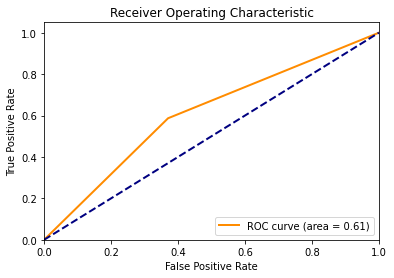

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

def adaboost(feature_list, pos_neg_list, num_iterations):
    num_samples = len(feature_list)
    weights = np.ones(num_samples) / num_samples
    classifiers = []

    for _ in range(num_iterations):
        # 训练一个弱分类器
        classifier = train_weak_classifier(feature_list, pos_neg_list, weights)
        
        # 计算分类器的错误率
        error = calculate_error(classifier, feature_list, pos_neg_list, weights)
        
        # 计算分类器的权重
        alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))
        
        # 更新样本权重
        predictions = predict(classifier, feature_list)
        incorrect = np.abs(predictions - pos_neg_list)
        weights *= np.exp(alpha * incorrect)
        
        # 归一化权重
        weights /= np.sum(weights)
        
        # 保存分类器及其权重
        classifiers.append((classifier, alpha))
    
    return classifiers

def train_weak_classifier(feature_list, pos_neg_list, weights):
    # 使用逻辑回归作为弱分类器
    classifier = LogisticRegression()
    classifier.fit(feature_list, pos_neg_list, sample_weight=weights)
    return classifier

def calculate_error(classifier, feature_list, pos_neg_list, weights):
    predictions = predict(classifier, feature_list)
    error = np.sum(weights * (predictions != pos_neg_list))
    return error / np.sum(weights)

def predict(classifier, feature_list):
    predictions = classifier.predict(feature_list)
    return predictions

def adaboost_predict(classifiers, feature_list):
    predictions = np.zeros(len(feature_list))
    for classifier, alpha in classifiers:
        predictions += alpha * predict(classifier, feature_list)
    return np.sign(predictions)

def plot_roc_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

# 生成虚拟数据作为示例
np.random.seed(0)
feature_list = np.random.rand(100, 10)
pos_neg_list = np.random.choice([-1, 1], size=100)

# 训练AdaBoost分类器
num_iterations = 10
classifiers = adaboost(feature_list, pos_neg_list, num_iterations)

# 预测并计算ROC曲线
predictions = adaboost_predict(classifiers, feature_list)
fpr, tpr, _ = roc_curve(pos_neg_list, predictions)

# 绘制ROC曲线
plot_roc_curve(fpr, tpr)


使用haar_like_feature函数计算所有的patch的特征参数

### 单张图片的多个Haar特征提取

In [ ]:
subwin_size = 12
image_test = np.copy(gray_images[20])
feature_list = []
h, w = image_test.shape
# 移动窗口并计算Haar特征
for i in range(0, h - subwin_size + 1, subwin_size):
    for j in range(0, w - subwin_size + 1, subwin_size):
        # 获取当前窗口
        window = image_test[i:i+subwin_size, j:j+subwin_size]
        feature = haar_like_feature(window,0,0,subwin_size-1,subwin_size-1)
        # print(feature.shape)
        feature_list.append(feature)
feature_list = np.array(feature_list)
print(feature_list.shape)

### 数据集的多个Haar特征提取

In [12]:
subwin_size = 12
feature_list = []
pos_neg_list = []
for img_index in range(len(X_train)):
    print(img_index)
    image_test = X_train[img_index]
    h, w = image_test.shape
    Leye_x, Leye_y, Reye_x, Reye_y, nose_x, nose_y, mouth_x, mouth_y = y_train[img_index]
    # 移动窗口并计算Haar特征
    for i in range(0, h - subwin_size + 1, subwin_size):
        for j in range(0, w - subwin_size + 1, subwin_size):
            # 获取当前窗口
            window = image_test[i:i+subwin_size, j:j+subwin_size]
            feature = haar_like_feature(window,0,0,subwin_size-1,subwin_size-1)
            # print(feature.shape)
            feature_list.append(feature)
            if i<=nose_x and nose_x<i+subwin_size and j<=nose_y and nose_y<j+subwin_size:
                pos_neg = 1
            else:
                pos_neg = -1
            pos_neg_list.append(pos_neg)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


In [13]:
# 保存为NumPy二进制文件
np.save('feature_list.npy', feature_list)


In [19]:
print(len(pos_neg_list))

160598


In [17]:
np.save('nose_list.npy', pos_neg_list)

month和eyes也采取相似的方法

In [24]:
subwin_size = 12
pos_neg_list_mouth = []
pos_neg_list_eyes = []
for img_index in range(len(X_train)):
    print(img_index)
    image_test = X_train[img_index]
    h, w = image_test.shape
    Leye_x, Leye_y, Reye_x, Reye_y, nose_x, nose_y, mouth_x, mouth_y = y_train[img_index]
    # 移动窗口并计算二分类标签
    for i in range(0, h - subwin_size + 1, subwin_size):
        for j in range(0, w - subwin_size + 1, subwin_size):
            # 获取当前窗口
            window = image_test[i:i+subwin_size, j:j+subwin_size]
            if i<=mouth_x and mouth_x<i+subwin_size and j<=mouth_y and mouth_y<j+subwin_size:
                pos_neg_mouth = 1
            else:
                pos_neg_mouth = -1
            pos_neg_list_mouth.append(pos_neg_mouth)
            if i <= Leye_x and Leye_x < i + subwin_size and j <= Leye_y and Leye_y < j + subwin_size:
                pos_neg_eye = 1
            # 判断右眼位置
            elif i <= Reye_x and Reye_x < i + subwin_size and j <= Reye_y and Reye_y < j + subwin_size:
                pos_neg_eye = 1
            else:
                pos_neg_eye = -1
            pos_neg_list_eyes.append(pos_neg_eye)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


In [26]:
np.save('mouth_list.npy', pos_neg_list_mouth)
np.save('eyes_list.npy', pos_neg_list_eyes)


### 多个Haar特征的Adaboost算法
不同的器官分开计算:nose

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

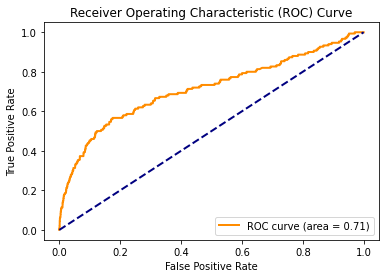

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Adaboost算法
def adaboost(feature_list, pos_neg_list, num_iterations):
    num_samples = len(feature_list)
    weights = np.ones(num_samples) / num_samples  # 初始化样本权重

    classifiers = []  # 用于存储弱分类器
    alphas = []  # 用于存储弱分类器的权重

    pos_neg_array = np.array(pos_neg_list)  # 将列表转换为NumPy数组

    for _ in range(num_iterations):
        # 训练弱分类器
        weak_classifier = LogisticRegression()
        weak_classifier.fit(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的误差
        error = 1 - weak_classifier.score(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的权重
        alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))

        # 更新样本权重
        weights *= np.exp(-alpha * pos_neg_array * weak_classifier.predict_proba(feature_list)[:, 1])
        weights /= np.sum(weights)

        # 存储分类器和权重
        classifiers.append(weak_classifier)
        alphas.append(alpha)

    return classifiers, alphas

# 计算ROC曲线
def plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list):
    num_samples = len(feature_list)
    scores = np.zeros(num_samples)

    for classifier, alpha in zip(classifiers, alphas):
        scores += alpha * classifier.predict_proba(feature_list)[:, 1]

    fpr, tpr, _ = roc_curve(pos_neg_list, scores)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# 运行Adaboost算法
classifiers, alphas = adaboost(feature_list, pos_neg_list, num_iterations=10)

# 绘制ROC曲线
plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list)


mouth

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

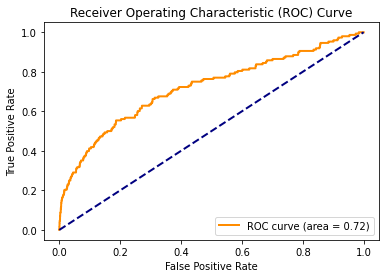

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Adaboost算法
def adaboost(feature_list, pos_neg_list_mouth, num_iterations):
    num_samples = len(feature_list)
    weights = np.ones(num_samples) / num_samples  # 初始化样本权重

    classifiers = []  # 用于存储弱分类器
    alphas = []  # 用于存储弱分类器的权重

    pos_neg_array = np.array(pos_neg_list_mouth)  # 将列表转换为NumPy数组

    for _ in range(num_iterations):
        # 训练弱分类器
        weak_classifier = LogisticRegression()
        weak_classifier.fit(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的误差
        error = 1 - weak_classifier.score(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的权重
        alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))

        # 更新样本权重
        weights *= np.exp(-alpha * pos_neg_array * weak_classifier.predict_proba(feature_list)[:, 1])
        weights /= np.sum(weights)

        # 存储分类器和权重
        classifiers.append(weak_classifier)
        alphas.append(alpha)

    return classifiers, alphas

# 计算ROC曲线
def plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list_mouth):
    num_samples = len(feature_list)
    scores = np.zeros(num_samples)

    for classifier, alpha in zip(classifiers, alphas):
        scores += alpha * classifier.predict_proba(feature_list)[:, 1]

    fpr, tpr, _ = roc_curve(pos_neg_list_mouth, scores)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# 运行Adaboost算法
classifiers, alphas = adaboost(feature_list, pos_neg_list_mouth, num_iterations=10)

# 绘制ROC曲线
plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list_mouth)


eyes

/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

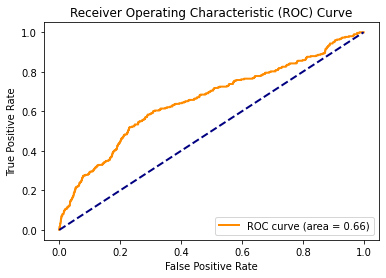

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

# Adaboost算法
def adaboost(feature_list, pos_neg_list_eyes, num_iterations):
    num_samples = len(feature_list)
    weights = np.ones(num_samples) / num_samples  # 初始化样本权重

    classifiers = []  # 用于存储弱分类器
    alphas = []  # 用于存储弱分类器的权重

    pos_neg_array = np.array(pos_neg_list_eyes)  # 将列表转换为NumPy数组

    for _ in range(num_iterations):
        # 训练弱分类器
        weak_classifier = LogisticRegression()
        weak_classifier.fit(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的误差
        error = 1 - weak_classifier.score(feature_list, pos_neg_array, sample_weight=weights)

        # 计算分类器的权重
        alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))

        # 更新样本权重
        weights *= np.exp(-alpha * pos_neg_array * weak_classifier.predict_proba(feature_list)[:, 1])
        weights /= np.sum(weights)

        # 存储分类器和权重
        classifiers.append(weak_classifier)
        alphas.append(alpha)

    return classifiers, alphas

# 计算ROC曲线
def plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list_eyes):
    num_samples = len(feature_list)
    scores = np.zeros(num_samples)

    for classifier, alpha in zip(classifiers, alphas):
        scores += alpha * classifier.predict_proba(feature_list)[:, 1]

    fpr, tpr, _ = roc_curve(pos_neg_list_eyes, scores)
    auc_score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# 运行Adaboost算法
classifiers, alphas = adaboost(feature_list, pos_neg_list_eyes, num_iterations=10)

# 绘制ROC曲线
plot_roc_curve(classifiers, alphas, feature_list, pos_neg_list_eyes)
